# Inputs and explanation

We will load the functions that we regressed (see tracking_code/making_calibration_models.ipynb), <br>
and create the residuals plots for the paper.

# Imports

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
from scipy.interpolate import interp1d
import scipy as sp
import pickle
import glob
#import cv2
#import pykalman
#"import seaborn as sns
#sns.set()
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from scipy.signal import savgol_filter, savgol_coeffs
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D  
#%matplotlib inline
#%matplotlib notebook
import time
%load_ext autoreload
import os
%autoreload 2


import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-white')
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from ipywidgets import Video, Image, VBox, Text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Panel A top right - 3D visualization of the beads for a single rotation without the corner points

In [10]:
calibration_folder_path = '../tracking_code/20200120_calibration/'    

# set the folder containing the calibration information
measured_coord_folder = os.path.join(calibration_folder_path, 'measured_coords/')
image_coord_folder = os.path.join(calibration_folder_path, 'image_coords/')

# make a list of the text files we need to read from each position folder
imcoord_textfileNames = ['Ex_data_corner.txt', 'Ex_data.txt', 'Ez_data_corner.txt', 'Ez_data.txt', \
                         'Fx_data_corner.txt', 'Fx_data.txt', 'Fy_data_corner.txt', 'Fy_data.txt', \
                         'Gy_data_corner.txt', 'Gy_data.txt', 'Gz_data_corner.txt', 'Gz_data.txt']

measured_textfileNames = ['pos1_measured.txt', 'pos1corner_measured.txt',
                          'pos2_measured.txt', 'pos2corner_measured.txt',
                          'pos3_measured.txt', 'pos3corner_measured.txt',
                          'pos4_measured.txt', 'pos4corner_measured.txt']

position_names = ['position1', 'position2', 'position3', 'position4']

# load the measured coordinates
measured_coordinates = []
for i in range(0, len(measured_textfileNames), 2):
    # get paths
    non_corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i])
    corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i+1])
    # load the data
    non_corner_data = np.loadtxt(non_corner_path)
    corner_data = np.loadtxt(corner_path)
    # combine the two
    position_measured_coords = np.concatenate((non_corner_data, corner_data))
    # record
    measured_coordinates.append(position_measured_coords)
full_measured_coordinates = np.vstack(measured_coordinates)

# load the image coordinates
xz_imCoords = []
xy_imCoords = []
yz_imCoords = []

for positionIdx in range(4):
    folder_name = os.path.join(image_coord_folder, position_names[positionIdx])
    
    Ex_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[0]))
    Ex_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[1]))
    Ez_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[2]))
    Ez_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[3]))
    Ex_data = np.concatenate((Ex_non_corner_data, Ex_corner_data))
    Ez_data = np.concatenate((Ez_non_corner_data, Ez_corner_data))
    
    Fx_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[4]))
    Fx_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[5]))
    Fy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[6]))
    Fy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[7]))
    Fx_data = np.concatenate((Fx_non_corner_data, Fx_corner_data))
    Fy_data = np.concatenate((Fy_non_corner_data, Fy_corner_data))
    
    Gy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[8]))
    Gy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[9]))
    Gz_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[10]))
    Gz_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[11]))
    Gy_data = np.concatenate((Gy_non_corner_data, Gy_corner_data))
    Gz_data = np.concatenate((Gz_non_corner_data, Gz_corner_data))
    
    # Combine the two arrays for each cam
    # BIG DANGER OF A SWAP! e.g (Ex,Ez), or (Ez,Ex)
    # WE WANT OPENCV FORMAT I THINK?
    xz_data = np.stack([Ex_data, Ez_data], axis=1)
    xy_data = np.stack([Fx_data, Fy_data], axis=1)
    yz_data = np.stack([Gy_data, Gz_data], axis=1)
    
    # record for this position
    xz_imCoords.append(xz_data)
    xy_imCoords.append(xy_data)
    yz_imCoords.append(yz_data)
    
# combine the data for each position
xz_imCoords = np.concatenate(xz_imCoords)
xy_imCoords = np.concatenate(xy_imCoords)
yz_imCoords = np.concatenate(yz_imCoords)

# combine into master array
full_image_coordinates = np.stack([xz_imCoords, xy_imCoords, yz_imCoords], axis=0)

# load the raw images (if you like - not necessary for regressing functions)
raw_image_folder = os.path.join(calibration_folder_path, 'raw_images')

image_extensions = ['xz_rotation1.tif', 'xz_rotation2.tif', 'xz_rotation3.tif', 'xz_rotation4.tif',
                    'xy_rotation1.tif', 'xy_rotation2.tif', 'xy_rotation3.tif', 'xy_rotation4.tif',
                    'yz_rotation1.tif', 'yz_rotation2.tif', 'yz_rotation3.tif', 'yz_rotation4.tif',
                    ]

image_filepaths = [os.path.join(raw_image_folder, image_extension) for image_extension in image_extensions]

# load the images as a list
images = []
for imPath in image_filepaths:
    images.append(plt.imread(imPath))
    
# turn into an array of shape (numCams, numRotations, 1024, 1280)
calibration_images = np.stack(images)
calibration_images = calibration_images.reshape(3,4,1024,1280)
print()
print('calibration_images_shape: ', calibration_images.shape)
print()
print()

print('-- Full Measured Coordinates --')
print('(numBalls, 3D_coord)')
print(full_measured_coordinates.shape)
print()
print('-- Full Image coordinates --')
print('(numCams, numBalls, 2D_coord)')
print(full_image_coordinates.shape)

total_numBalls = full_measured_coordinates.shape[0]
print(total_numBalls)


calibration_images_shape:  (3, 4, 1024, 1280)


-- Full Measured Coordinates --
(numBalls, 3D_coord)
(200, 3)

-- Full Image coordinates --
(numCams, numBalls, 2D_coord)
(3, 200, 2)
200


In [11]:
# parse the image coordinates - we only want to use calibration balls which lie within the interior volume

def is_within_interior_cage(XYZ):
    ''' Return True if this 3D values is within the iterior cage,
        False otherwise
    '''
    # define the X, Y and Z ranges of the iterior cage
    iterior_cage_lims = np.array([[5,35],[5,35],[0,32]])
    #iterior_cage_lims = np.array([[0,40],[0,40],[0,40]])

    # preallocate a list to hold the success for the checking of each dimension
    dim_successes = [False]*3
    # check each dimension, does component lie within the cage component limits?
    for i,dim_range in enumerate(iterior_cage_lims):
        if dim_range[0] <= XYZ[i] <= dim_range[1]:
            dim_successes[i] = True
    # If all 3 are successes, then we return True
    if np.all(dim_successes):
        return True
    else:
        return False
    
    
new_meas_list = []
new_im_list = []
within_mask = np.zeros((total_numBalls,), dtype=bool)

for ballIdx in range(total_numBalls):
    if is_within_interior_cage(full_measured_coordinates[ballIdx]):
        new_meas_list.append(full_measured_coordinates[ballIdx])
        new_im_list.append(full_image_coordinates[:,ballIdx])
        within_mask[ballIdx] = True

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
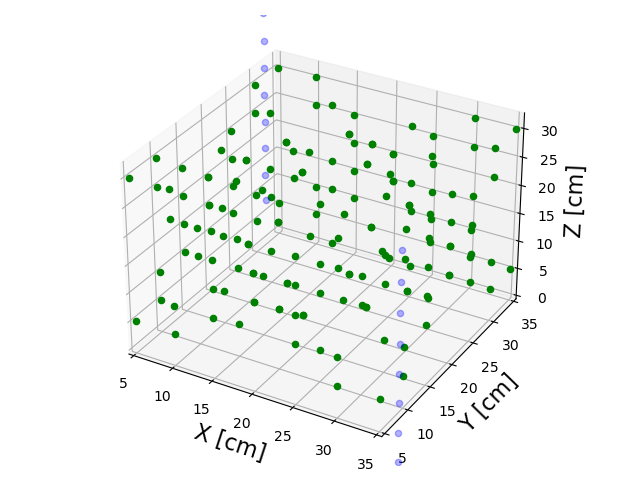

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c='g', depthshade=False)
c=[1,1,0.1,1]

ax.scatter(full_measured_coordinates[~within_mask,0], 
           full_measured_coordinates[~within_mask,1], 
           full_measured_coordinates[~within_mask,2], 
           marker='o', c=[0,0,1,0.3], depthshade=False)

ax.set_xlabel('X [cm]', fontsize=16)
ax.set_ylabel('Y [cm]', fontsize=16)
ax.set_zlabel('Z [cm]', fontsize=16)
ax.set_xlim(5,35)
ax.set_ylim(5,35)
ax.set_zlim(0,32)

ax.set_xticks([5,10,15,20,25,30,35])
ax.set_yticks([5,10,15,20,25,30,35])
ax.set_zticks([0,5,10,15,20,25,30])


#ax.tick_params(axis="both", labelsize=14)

plt.tight_layout() #Tatsuo added 20221030
# plt.savefig('calibration_structure.pdf')
# plt.savefig('calibration_structure.png', dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
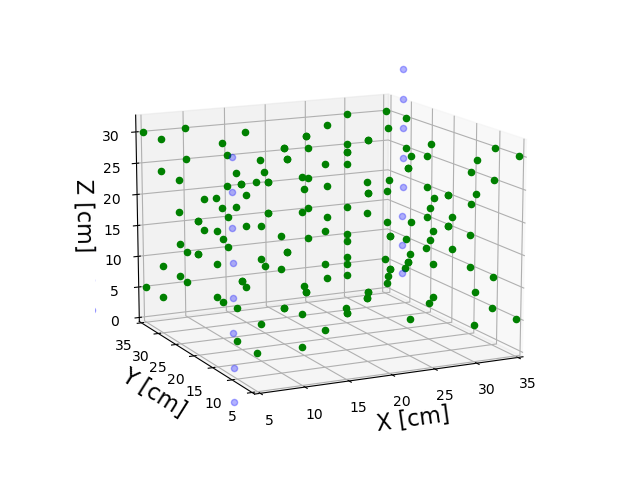

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c='g', depthshade=False)
c=[1,1,0.1,1]

ax.scatter(full_measured_coordinates[~within_mask,0], 
           full_measured_coordinates[~within_mask,1], 
           full_measured_coordinates[~within_mask,2], 
           marker='o', c=[0,0,1,0.3], depthshade=False)

ax.set_xlabel('X [cm]', fontsize=16)
ax.set_ylabel('Y [cm]', fontsize=16)
ax.set_zlabel('Z [cm]', fontsize=16)
ax.set_xlim(5,35)
ax.set_ylim(5,35)
ax.set_zlim(0,32)

ax.set_xticks([5,10,15,20,25,30,35])
ax.set_yticks([5,10,15,20,25,30,35])
ax.set_zticks([0,5,10,15,20,25,30])

ax.view_init(elev=13, azim=-116)

#ax.tick_params(axis="both", labelsize=14)

plt.tight_layout() #Tatsuo added 20221030
# plt.savefig('calibration_structure.pdf')
# plt.savefig('calibration_structure.png', dpi=300)

/tmp/ipykernel_2178142/2725557248.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
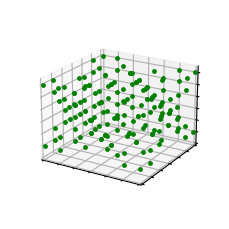

In [21]:
fig = plt.figure(figsize=(2.3,2.3))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c='g', depthshade=False, s=6)
c=[1,1,0.1,1]

# ax.scatter(full_measured_coordinates[~within_mask,0], 
#            full_measured_coordinates[~within_mask,1], 
#            full_measured_coordinates[~within_mask,2], 
#            marker='o', c=[0,0,1,0.3], depthshade=False)

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize=16)
ax.set_zlabel('', fontsize=16)
ax.set_xlim(5,35)
ax.set_ylim(5,35)
ax.set_zlim(0,32)
ax.tick_params(axis="both", labelsize=14)

ax.view_init(elev=21, azim=-59)

ax.set_xticks([5,10,15,20,25,30,35])
ax.set_yticks([5,10,15,20,25,30,35])
ax.set_zticks([0,5,10,15,20,25,30])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

fig.tight_layout() 
#fig.savefig('/home/liam/temp/image_transfer/SI_calibration_panelB.png', dpi=300, transparent=True)

# Panel B

## prepare the data for computing residuals

In [24]:
# Now define measured and image coordinates to only use interior points
measured_coordinates = full_measured_coordinates[within_mask]
image_coordinates = full_image_coordinates[:, within_mask]

print(measured_coordinates.shape)
print(image_coordinates.shape)

numBalls = measured_coordinates.shape[0]
print(numBalls)

(168, 3)
(3, 168, 2)
168


In [25]:
# prepare the image coordinates 
xz_xy_image_coordinates = np.copy(image_coordinates[:2,:,:].swapaxes(0,1).reshape(numBalls, -1))
xy_yz_image_coordinates = np.copy(image_coordinates[1:,:,:].swapaxes(0,1).reshape(numBalls, -1))
xz_yz_image_coordinates = np.copy(image_coordinates[::2,:,:].swapaxes(0,1).reshape(numBalls, -1))

xz_image_coordinates = np.copy(image_coordinates[0,:,:])
xy_image_coordinates = np.copy(image_coordinates[1,:,:])
yz_image_coordinates = np.copy(image_coordinates[2,:,:])

# I need to transform from (numCams,numBalls,2) to (numBalls,6)
flat_image_coordinates = np.copy(image_coordinates.swapaxes(0,1).reshape(-1,6))

print(xz_xy_image_coordinates.shape)
print(xy_yz_image_coordinates.shape)
print(xz_yz_image_coordinates.shape)
print()
print(xz_image_coordinates.shape)
print(xy_image_coordinates.shape)
print(yz_image_coordinates.shape)
print()
print(measured_coordinates.shape)
print()
print(flat_image_coordinates.shape)

(168, 4)
(168, 4)
(168, 4)

(168, 2)
(168, 2)
(168, 2)

(168, 3)

(168, 6)


## XZ&XY to YZ

In [26]:
X_data = np.copy(xz_xy_image_coordinates)
Y_data = np.copy(yz_image_coordinates)

In [27]:
# ---- compute the final residuals plot ---- #

# load the model
yz_getter_name = 'xz_xy_to_yz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));


calculated_im_coordinates = yz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
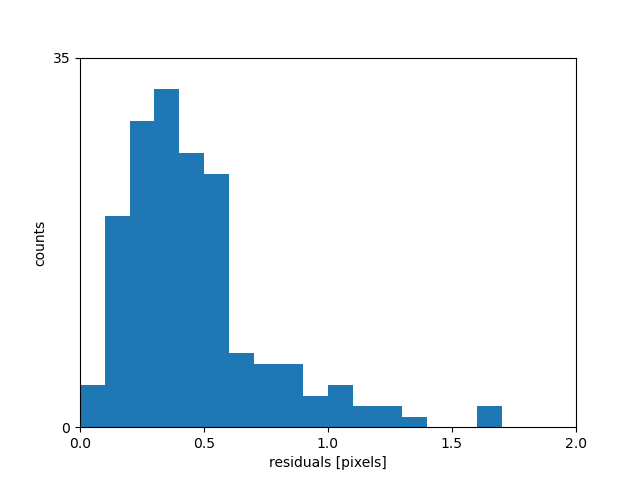

In [28]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
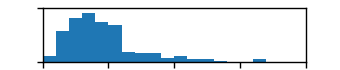

In [29]:
fig, axs = plt.subplots(figsize=(3.4,0.7))
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])

# ---------------------------#
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
#for axis in ['right']:
#    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_calibration_YZ_residuals.png'
#fig.savefig(imsavepath, transparent=True, dpi=300)

## XY&YZ to XZ

In [30]:
X_data = np.copy(xy_yz_image_coordinates)
Y_data = np.copy(xz_image_coordinates)

In [31]:
# ---- compute the final residuals plot ---- #

# load the model
xz_getter_name = 'xy_yz_to_xz.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));


calculated_im_coordinates = xz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
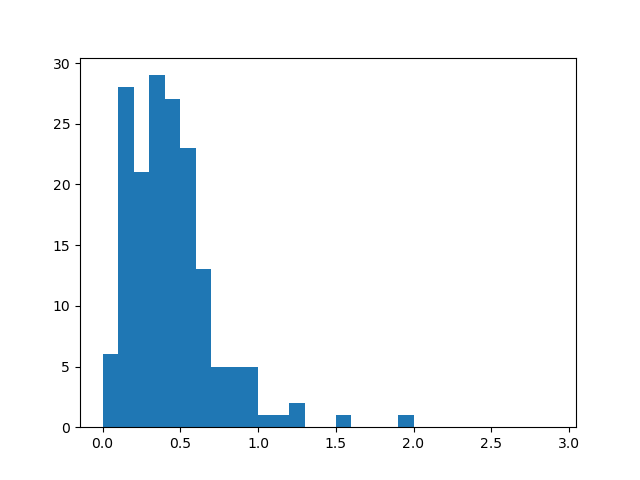

In [32]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
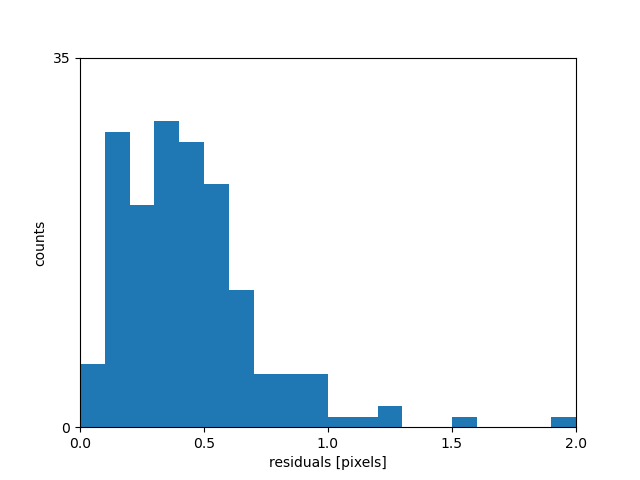

In [33]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
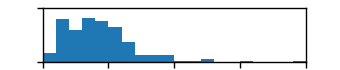

In [34]:
fig, axs = plt.subplots(figsize=(3.4,0.7))
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])

# ---------------------------#
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
#for axis in ['right']:
#    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_calibration_XZ_residuals.png'
fig.savefig(imsavepath, transparent=True, dpi=300)

## XZ&YZ to XY

In [35]:
X_data = np.copy(xz_yz_image_coordinates)
Y_data = np.copy(xy_image_coordinates)

In [36]:
# ---- compute the final residuals plot ---- #

# load the model
xy_getter_name = 'xz_yz_to_xy.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xy_getter = load(os.path.join(python_calibration_folderPath, xy_getter_name));


calculated_im_coordinates = xy_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
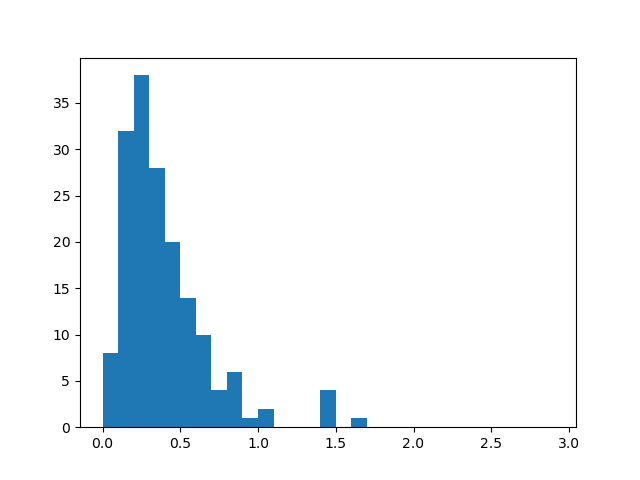

In [37]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
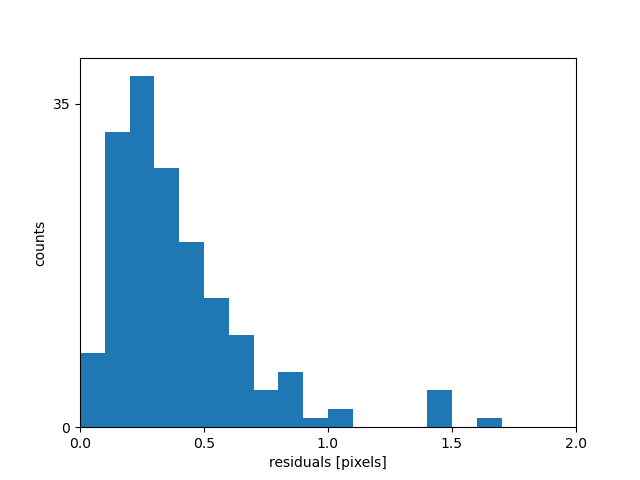

In [38]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 40)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 35])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
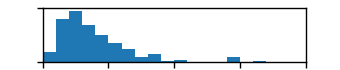

In [39]:
fig, axs = plt.subplots(figsize=(3.4,0.7))
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 3, 0.1)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [pixels]')

ax.set_xlim(0, 2)
ax.set_ylim(0, 35)

ax.set_xticks([0, 0.5, 1, 1.5, 2]);
ax.set_yticks([0, 40])

# ---------------------------#
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
#for axis in ['right']:
#    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_calibration_XY_residuals.png'
fig.savefig(imsavepath, transparent=True, dpi=300)

## XZ&XY&YZ to XYZ

In [40]:
X_data = np.copy(flat_image_coordinates)
Y_data = np.copy(measured_coordinates)

In [41]:
# ---- compute the final residuals plot ---- #

# load the model
xyz_getter_name = 'imCoords_to_XYZ.joblib'

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
xyz_getter = load(os.path.join(python_calibration_folderPath, xyz_getter_name));


calculated_im_coordinates = xyz_getter.predict(X_data)

residuals = np.linalg.norm(Y_data - calculated_im_coordinates , axis=1)
residuals.shape

(168,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
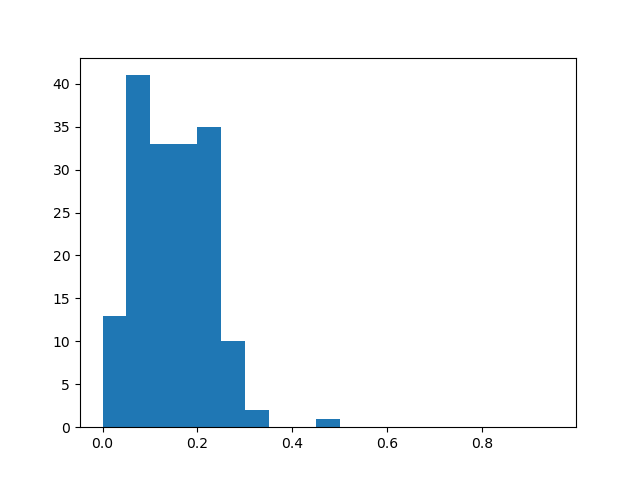

In [42]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 1, 0.05)

ax.hist(residuals, bins=bins);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
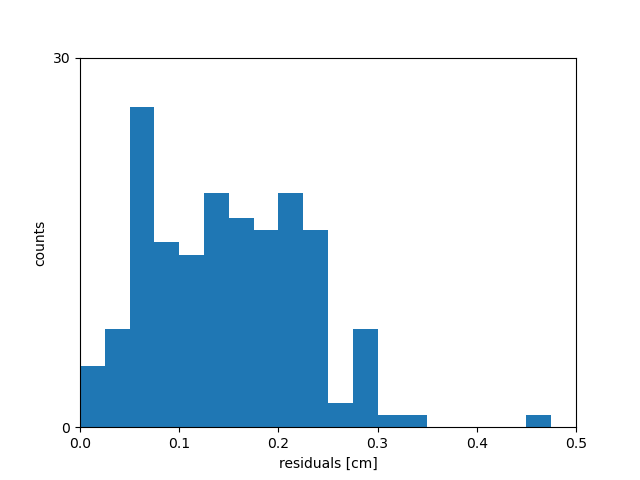

In [43]:
fig, axs = plt.subplots()
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 0.8, 0.025)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [cm]')

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 30)

ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5]);
ax.set_yticks([0, 30])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
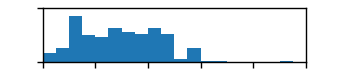

In [44]:
fig, axs = plt.subplots(figsize=(3.4,0.7))
ax = axs

# the binning for plotting the residuals
bins = np.arange(0, 0.8, 0.025)

ax.hist(residuals, bins=bins);

ax.set_ylabel('counts')
ax.set_xlabel('residuals [cm]')

ax.set_xlim(0, 0.5)
ax.set_ylim(0, 30)

ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5]);
ax.set_yticks([0, 30])

# ---------------------------#
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
#for axis in ['right']:
#    ax.spines[axis].set_visible(False)

#fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_calibration_XYZ_residuals.png'
fig.savefig(imsavepath, transparent=True, dpi=300)